In [1]:
import sys
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.naive_bayes as nb

from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

sys.path.insert(0, '/Users/diol5851/Documents/rental-housing-cost/')
from notebooks.data_cleaning_EDA.AHS_Parser import AHS_Parser
sys.path.remove('/Users/diol5851/Documents/rental-housing-cost/')

In [2]:
def get_dataset(year):
    raw_dat = pd.read_feather(f'../../data/AHS_{year}.feather')
    # Drop the year column, since that does not add information here.
    dat = raw_dat.drop(columns=['YEAR'])
    # Move ADEQUACY to the first column.
    adequacy = dat.pop('ADEQUACY')
    dat.insert(0, 'ADEQUACY', adequacy)
    # Drop apartments with four or more bathrooms.
    dat = dat[dat['BATHROOMS'] < 4]
    # Remap the ADEQUACY column to a binary column, where 1 is adequate.
    ad_default = defaultdict(lambda: 0)
    ad_default['Adequate'] = 1
    dat['ADEQUACY'] = dat['ADEQUACY'].map(ad_default)
    # Dropping columns that seem redundant for prediction.
    dat = dat.drop(columns = [
        'UTILAMT', 'HOAAMT', 'INSURAMT', 'FINCP', 'KITCHENS', 'DINING', 'LAUNDY', 'GARAGE', 'PORCH',
        'NUMNONREL', 'HHADLTKIDS', 'SUBDIV'
        ])
    # Parse the remaining categorical columns.
    parser = AHS_Parser()
    for col in dat.select_dtypes(include=['object']).columns:
        dat[col] = dat[col].astype('category')
        dat[col] = dat[col].cat.rename_categories(parser.parse_categorical(col, year))
        if 'Not reported' in dat[col].cat.categories:
            dat[col] = dat[col].cat.remove_categories(['Not reported'])
    # Drop columns with less than 20k non-null values.
    dat = dat.drop(columns = dat.columns[dat.count() < 20e3])
    # Drop all remaining null values.
    dat = dat.dropna()
    return dat

In [3]:
# Pull the 2023 AHS data.
dat = get_dataset(2023)
dat.drop(columns=['OMB13CBSA', 'ROACH', 'RODENT', 'SEWBREAK'], inplace=True)
dat.info()

## Generate training and testing sets that are balanced.
dat_adequate = dat[dat['ADEQUACY'] == 1]
dat_not_adequate = dat[dat['ADEQUACY'] == 0]
# Split the two dataframes into training and testing sets.
adequate_train, adequate_test = train_test_split(dat_adequate, test_size=0.2, random_state=42)
not_adequate_train, not_adequate_test = train_test_split(dat_not_adequate, test_size=0.2, random_state=42)
# Combine the training and test sets.
train = pd.concat([adequate_train, not_adequate_train])
test = pd.concat([adequate_test, not_adequate_test])

<class 'pandas.core.frame.DataFrame'>
Index: 19997 entries, 0 to 55667
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADEQUACY    19997 non-null  int64   
 1   BLD         19997 non-null  category
 2   STORIES     19997 non-null  int64   
 3   YRBUILT     19997 non-null  int64   
 4   RENT        19997 non-null  int64   
 5   RENTSUB     19997 non-null  category
 6   TOTHCAMT    19997 non-null  int64   
 7   UNITFLOORS  19997 non-null  int64   
 8   BATHROOMS   19997 non-null  float64 
 9   BEDROOMS    19997 non-null  int64   
 10  TOTROOMS    19997 non-null  int64   
 11  ACPRIMARY   19997 non-null  category
 12  HEATTYPE    19997 non-null  category
 13  HOTWATER    19997 non-null  category
 14  SEWTYPE     19997 non-null  category
 15  WATSOURCE   19997 non-null  category
 16  COOKTYPE    19997 non-null  category
 17  DRYER       19997 non-null  category
 18  HINCP       19997 non-null  int64   
 19  NUMPEOPLE

## Gaussian Naive Bayes for Numerical Columns

In [4]:
## Implememnt Gaussian Naive Bayes on numerical data. ##
y = train['ADEQUACY']
X = train.drop(columns=['ADEQUACY']).select_dtypes(exclude=['category'])
gnb = nb.GaussianNB()
gnb.fit(X, y)

GaussianNB()

In [5]:
# Predict the test set.
y_pred = gnb.predict(test.drop(columns=['ADEQUACY']).select_dtypes(exclude=['category']))

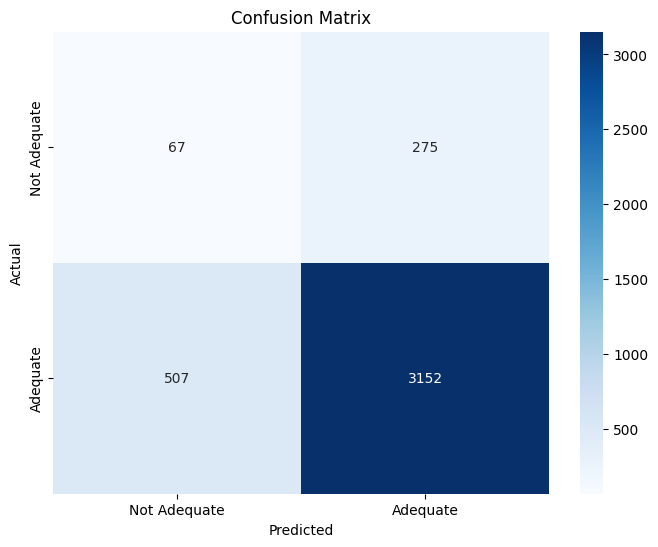

Accuracy: 0.805


In [6]:
# Plot confusion matrix.
cm = confusion_matrix(test['ADEQUACY'], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Adequate', 'Adequate'], yticklabels=['Not Adequate', 'Adequate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Print the model accuracy.
accuracy = cm.diagonal().sum() / cm.sum()
print(f'Accuracy: {accuracy:.3f}')

Model Classes: [0 1]


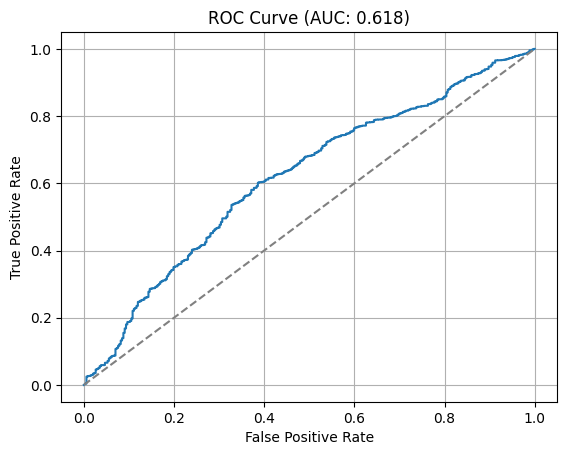

In [7]:
print(f'Model Classes: {gnb.classes_}')
# Plot ROC curve.
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(
    test['ADEQUACY'], 
    gnb.predict_proba(test.drop(columns=['ADEQUACY']).select_dtypes(exclude=['category']))[:, 1]
)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title(f'ROC Curve (AUC: {roc_auc:.3f})')
plt.show()

## Categorical Naive Bayes

In [8]:
cat_dat = dat.select_dtypes(include=['category'])

## Must encode the cateogorical variables before fitting the model.
from sklearn.preprocessing import LabelEncoder

for col in cat_dat.columns:
    # This does not save the encoders, which is fine for generating on a static dataset,
    # but if we want to use this model in production, we will need to save the encoders
    # for each column to transform data the same way.
    le = LabelEncoder()
    cat_dat[col] = le.fit_transform(cat_dat[col])

## Add the target to the data.
cat_dat['ADEQUACY'] = dat['ADEQUACY']

## Split into training and testing sets.
cat_adequate_train, cat_adequate_test = train_test_split(cat_dat[cat_dat['ADEQUACY'] == 1], test_size=0.2, random_state=42)
cat_not_adequate_train, cat_not_adequate_test = train_test_split(cat_dat[cat_dat['ADEQUACY'] == 0], test_size=0.2, random_state=42)
# Combine the training and test sets.
cat_train = pd.concat([cat_adequate_train, cat_not_adequate_train])
cat_test = pd.concat([cat_adequate_test, cat_not_adequate_test])

In [9]:
# Separate the target from the features.
y = cat_train['ADEQUACY']
X = cat_train.drop(columns=['ADEQUACY'])
# Fit the model.
cnb = nb.CategoricalNB()
cnb.fit(X, y)

CategoricalNB()

In [10]:
# Predict test set labels.
y_pred = cnb.predict(cat_test.drop(columns=['ADEQUACY']))

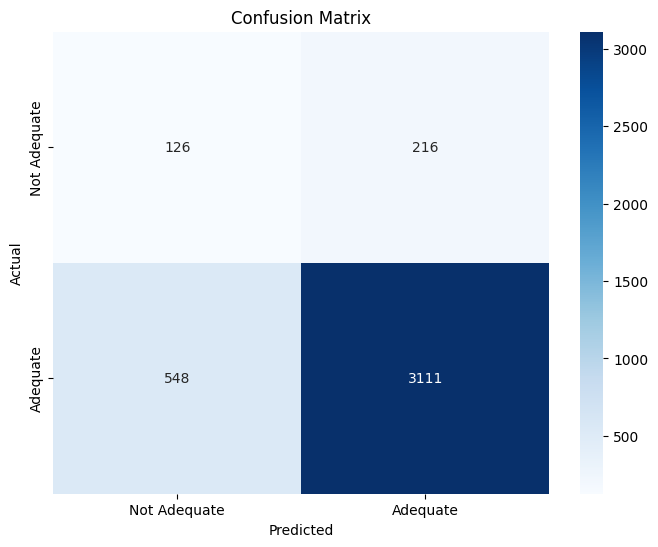

Accuracy: 0.809


In [11]:
# Plot confusion matrix.
cm = confusion_matrix(cat_test['ADEQUACY'], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Adequate', 'Adequate'], yticklabels=['Not Adequate', 'Adequate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Print the model accuracy.
accuracy = cm.diagonal().sum() / cm.sum()
print(f'Accuracy: {accuracy:.3f}')

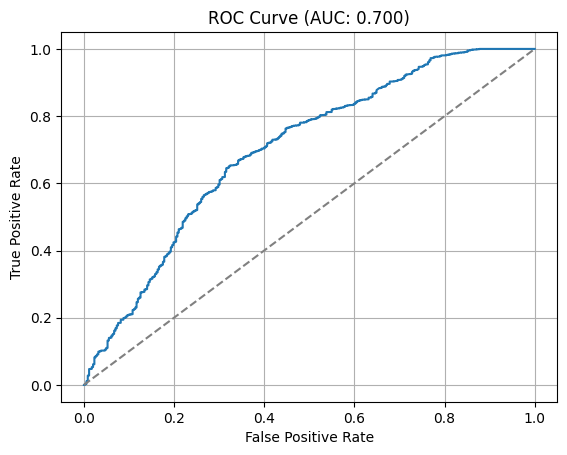

In [12]:
## Plot ROC curve.
fpr, tpr, _ = roc_curve(
    cat_test['ADEQUACY'], 
    cnb.predict_proba(cat_test.drop(columns=['ADEQUACY']))[:, 1]
)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title(f'ROC Curve (AUC: {roc_auc:.3f})')
plt.show()

## Multinomial Naive Bayes

This lends itself to text data, so we'll go ahead and train a model to distinguish between articles talking about cars and those talking about housing cost.

In [22]:
rent_txt = pd.read_csv('../../data/rent_articles.csv', sep=';', header=None)
car_txt = pd.read_csv('../../data/car_articles.csv', sep=';', header=None)
# Add label columns to the dataframes.
rent_txt['Label'] = 'Rent'
car_txt['Label'] = 'Car'
text_df = pd.concat([rent_txt, car_txt])

## Encode text data with sklearn.
from sklearn.feature_extraction.text import CountVectorizer
tokenizer = CountVectorizer(
    stop_words='english',
    lowercase=True,
)
X = tokenizer.fit_transform(text_df[0])
y = text_df['Label']

In [24]:
## Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit the multinomial model.
mnb = nb.MultinomialNB()
mnb.fit(X_train, y_train)

## Predict test set labels.
y_pred = mnb.predict(X_test)
mnb.classes_

array(['Car', 'Rent'], dtype='<U4')

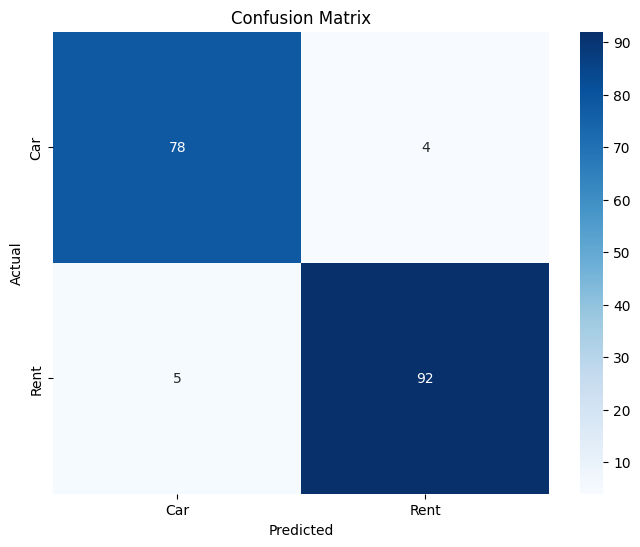

Accuracy: 0.950


In [26]:
# Plot confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = mnb.classes_, yticklabels = mnb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Print the model accuracy.
accuracy = cm.diagonal().sum() / cm.sum()
print(f'Accuracy: {accuracy:.3f}')

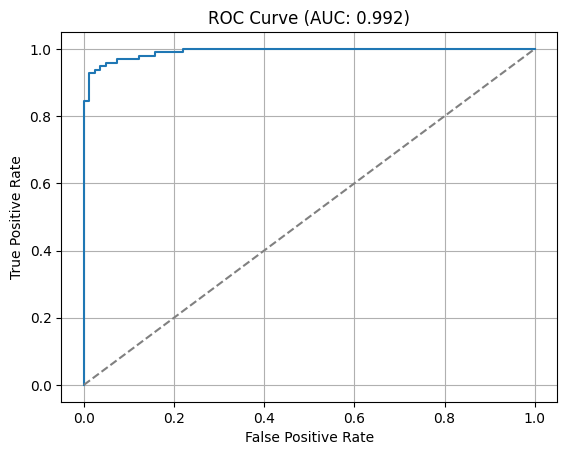

In [28]:
## Plot ROC curve.
fpr, tpr, _ = roc_curve(
    y_test.map({'Car': 0, 'Rent': 1}),
    mnb.predict_proba(X_test)[:, 1]
)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title(f'ROC Curve (AUC: {roc_auc:.3f})')
plt.show()